## Random walks sampling

The node2vec algorithm is fitted on pairs of target nodes and their context. These pairs are taken form sequences of parameterized random walks sampled from the brain graph. 


<img src="https://raw.githubusercontent.com/GidLev/cepy/master/examples/random_walks.png" alt="Random walks sampling" width = 394 height = 193/>



In the notebook we will go over the details of the random walks generation.

We will start by importing some relevant packages:

In [14]:
%%capture
!pip install cepy
!pip install seaborn
!pip install -U scikit-learn
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib
import seaborn as sns
import pandas as pd
import networkx as nx
import cepy as ce

Download the structural connectivity data:


In [15]:
%%capture

# structural connectivity matrix
!wget -O sub1_sc_matrix.npz 'https://github.com/GidLev/cepy/blob/master/examples/sub1_sc_matrix.npz?raw=true';
sc_mat = np.load('sub1_sc_matrix.npz')['x']

# nodes labels
!wget -O schaefer200_yeo17_nodeName.csv 'https://github.com/GidLev/cepy/blob/master/examples/schaefer200_yeo17_nodeName.csv?raw=true';

## Sample random walk from the structural connectivity (SC) matrix:

First, let plot the SC matrix:




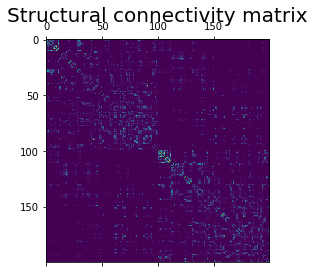

In [16]:
# plot the SC matrix
plt.matshow(np.log1p(sc_mat)) # we use a logarithmic transformation due to the weights distributions
plt.title('Structural connectivity matrix', size=20);

Applying an L1 normalization resutlts in the transition matrix of an unbiased random walk:

In [17]:
column_sums = np.sum(sc_mat,axis=1)
sc_mat_l1 = sc_mat / column_sums[:, np.newaxis]

In the node2vec algorithm, we generate parameterized random walks. The are guided by two parameters, the return parameter p and the in-out parameter q (Grover & Leskovec, 2016). The parameter p sets the likelihood for a random walker to immediately revisit a node, i.e. that its step at time t+1 would be the same node visited in time t-1. The parameter q controls the likelihood of a random walker to visit nodes that are not directly linked to the node visited in the previous step, i.e. that its step in time t+1 would be to a node with edge = 0 with the node visited in time t-1. 

<img src="https://raw.githubusercontent.com/GidLev/cepy/master/examples/p_q_parames.png" alt="p and q parameters" width="345" height = "320"/>

Let's define the transition function:

In [18]:
def alpha(mat,t_prev,t_next,p,q):
    '''The random walker transition function'''
    if t_prev==t_next:
        return 1.0/p
    elif mat[t_prev,t_next]>0:
        return 1.0
    else:
        return 1.0/q
p, q= 0.1, 1.6 # set p and q as in the paper

Then create a dictionary containing all the probability transitions:

In [19]:
num_nodes=sc_mat.shape[0]
prob_transition = {} # Initiate the dictionary
for t_prev in np.arange(sc_mat.shape[0]):
    for t in np.arange(sc_mat.shape[1]):
        #if edge t-1 to t exists
        if sc_mat_l1[t_prev,t]>0:
            pi=np.zeros(num_nodes)
            for t_next in np.arange(num_nodes):
                #if edge from t to t+1 exists. i.e  possible next node
                if sc_mat_l1[t,t_next]>0:
                    pi[t_next]=alpha(sc_mat_l1,t_prev,t,p,q)*sc_mat_l1[t,t_next]
                    #pi[t_next] is an unormlized transion probability from t to t_next given t_prev as the previous step
            pi=pi/np.sum(pi)
            #now, pi is normalzied transion probabilities for t traversed from t_prev
            prob_transition[t_prev,t]=pi

Now let's sample a random walk sequence from the pre-computed transition probabilities:

In [20]:
walk_length = 20 # as in the paper
all_nodes = np.arange(num_nodes)
#Let's start a random walk a random node
first_node = np.random.randint(num_nodes)
# The first step is sampled based only on edge values 
second_node = np.random.choice(all_nodes, 1, p=sc_mat_l1[first_node,:] / sc_mat_l1[first_node,:].sum())[0]
# The following steps will follow the transition function we defined
random_walk=[first_node,second_node]
for i in np.arange(walk_length-2):
    node_t = random_walk[-1]
    node_t_prev = random_walk[-2]
    next_node=np.random.choice(all_nodes, 1, p=prob_transition[node_t_prev,node_t])[0]
    random_walk.append(next_node)

Now let's look at the sampled random walk:

In [21]:
# get the nodes names:
nodes_indices = np.arange(num_nodes)
nodes_labels = pd.read_csv('schaefer200_yeo17_nodeName.csv', header=None).iloc[:,0].tolist()
nodes_labels = [node[11:] for node in nodes_labels]

nodes_index_to_label = dict(zip(nodes_indices, nodes_labels)) 
random_walk_nodes_labels = list(map(nodes_index_to_label.get, random_walk))

print('Random walk nodes indices:', random_walk)
print('Random walk nodes names:', random_walk_nodes_labels)

Random walk nodes indices: [147, 146, 185, 30, 131, 103, 130, 178, 42, 90, 142, 12, 37, 57, 96, 4, 11, 5, 2, 53]
Random walk nodes names: ['RH_SalVentAttnA_FrMed_2', 'RH_SalVentAttnA_FrMed_1', 'RH_DefaultA_PCC_1', 'LH_DorsAttnA_TempOcc_3', 'RH_DorsAttnA_TempOcc_2', 'RH_VisCent_ExStr_4', 'RH_DorsAttnA_TempOcc_1', 'RH_ContB_PFCmp_1', 'LH_SalVentAttnA_Ins_3', 'LH_DefaultB_PFCd_4', 'RH_SalVentAttnA_PrC_1', 'LH_SomMotA_1', 'LH_DorsAttnB_PostC_4', 'LH_ContA_IPS_1', 'LH_DefaultC_Rsp_1', 'LH_VisCent_ExStr_5', 'LH_VisPeri_ExStrSup_6', 'LH_VisCent_ExStr_6', 'LH_VisCent_ExStr_3', 'LH_Limbic_TempPole_2']


In practice we use cepy's more efficient implamentation:

In [22]:
ce_model = ce.CE(dimensions=30, walk_length=walk_length, 
                    num_walks=2, save_walks = True) # Precompute probabilities and generate walks
ce_model.fit(sc_mat)                    
random_walk = [[int(float(j)) for j in i] for i in ce_model.walks] # nodes apear as strings, converting to integers
print('Random walk nodes indices:',random_walk[0])

random_walk_nodes_labels = list(map(nodes_index_to_label.get, random_walk[0]))
print('Random walk nodes names:', random_walk_nodes_labels)


/usr/local/lib/python3.6/dist-packages/cepy/ce.py:109: UserWarning: num_walks is recommended to be at least 800, but is 2.
  warnings.warn('num_walks is recommended to be at least 800, but is ' + str(num_walks) + '.')


Start training  100  word2vec models on  1 threads.
Random walk nodes indices: [65, 76, 65, 81, 69, 82, 6, 4, 6, 8, 7, 9, 105, 141, 150, 171, 72, 36, 34, 40]
Random walk nodes names: ['LH_ContA_Cinga_1', 'LH_DefaultA_PCC_1', 'LH_ContA_Cinga_1', 'LH_DefaultA_PFCm_3', 'LH_ContB_PFClv_1', 'LH_DefaultB_Temp_1', 'LH_VisPeri_ExStrSup_1', 'LH_VisCent_ExStr_5', 'LH_VisPeri_ExStrSup_1', 'LH_VisPeri_ExStrSup_3', 'LH_VisPeri_ExStrSup_2', 'LH_VisPeri_ExStrSup_4', 'RH_VisCent_ExStr_6', 'RH_SalVentAttnA_ParOper_1', 'RH_SalVentAttnB_IPL_1', 'RH_ContB_Temp_2', 'LH_ContC_pCun_2', 'LH_DorsAttnB_PostC_3', 'LH_DorsAttnB_PostC_1', 'LH_SalVentAttnA_Ins_1']


### references

* https://github.com/apple2373/node2vec/ (source for parts of the random walk generation code)
* Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In Advances in neural information processing systems (pp. 3111-3119).‏
* Rosenthal, G., Váša, F., Griffa, A., Hagmann, P., Amico, E., Goñi, J., ... & Sporns, O. (2018). Mapping higher-order relations between brain structure and function with embedded vector representations of connectomes. Nature communications, 9(1), 1-12.‏